In [25]:
import torch

import dlc_practical_prologue as prologue
import math
torch.set_grad_enabled(False)

# Implementing modules

In [26]:

class Module ( object ) :
    def __call__(self, *args, **kwargs):
        return self.forward(*args)
    def forward ( self , * input ) :
        raise NotImplementedError
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    def param ( self ) :
        return []



In [27]:

'''
Applies a linear transformation to the incoming data: y = xA^T + b

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Attributes:
    weight: the learnable weights of the module 
    bias:   the learnable bias of the module of shape 


'''
class Linear(Module):

    def __init__(self, in_features, out_features, bias = True):
        self.in_features = in_features
        self.out_features = out_features

        
        # Initialize weight and bias
        # according to https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073
        
        if bias:
            self.bias = torch.empty(1,out_features)
        self.weight = torch.empty(in_features,out_features)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
        
        # cache the input whenever we go forward
        self.x = 0
        self.grad_weight = torch.empty(in_features,out_features)
        self.grad_bias = torch.empty(1,out_features)
            
        
    #Applies a linear transformation to the incoming data: y = xA^T + b   
    def forward(self,input):
        self.x = input
        output = input.mm(self.weight)
        if self.bias is not None:
            output += self.bias

        return output


    def backward(self,input):
        x = self.x
        w = self.weight
        b = self.bias
        
        # divide weigthts by batch size 
        # inspiration from https://stats.stackexchange.com/questions/183840/sum-or-average-of-gradients-in-mini-batch-gradient-decent
        db = input.sum(0).div(input.size()[0])
        dx = input.mm(w.t())
        dw = x.t().mm(input).div(input.size()[0])
        
        

        self.grad_bias += db
        self.grad_weight += dw


        return dx
            

    def param(self):
        return[(self.weight,self.grad_weight),(self.bias,self.grad_bias)]




In [28]:
'''
Applies the element-wise function Rectified Linear Unit

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

'''
class ReLU(Module):
    def __init_(self):
        self.x = 0
    def forward( self,  input ):
        self.x = input
        s1 = input.clamp(min=0)
        return s1
    def backward(self, input):
        return (self.x>0).float()*input
    
        
        
    

In [29]:
'''
Applies the element-wise function Hyperbolic Tangent

'''

class Tanh(Module):
    def __init_(self):
        self.x = 0
        
    def forward(self,input):
        self.x = input
        s1 = input.tanh()
        return s1

    def backward(self, input):
            ds_dx = 1 - self.x.tanh().pow(2)
            dl_dx = ds_dx * input
            return dl_dx
        

In [30]:
'''
A sequential container.
Modules are added to it in the order they are passed in the constructor - in a list.

'''
class Sequential(Module):
    def __init__(self, param ):
        super().__init__()
        self.model = (param)
        
    def forward(self,x):
        for _ in self.model:
            x = _.forward(x)
        return x
    def backward(self,x):
        for _ in reversed(self.model):
            x = _.backward(x)
        return x
    
    def param(self):
        param_list = []
        for module in self.model:
            param_list.extend(module.param())

        return param_list

In [31]:
'''
Returns mean square error loss
Creates a criterion that measures the mean squared error (squared L2 norm) between each element in the input v and target t .
The reduction here is sum
'''

class MSELoss(Module):
    def forward(self,v,t):
        return (v-t).pow(2).sum(0).sum()
    def dloss(self,v,t):
        return (2*(v-t))
        
        

In [32]:
'''
To construct an Optimizer you have to give it an iterable containing the parameters (all should be Variable s) to optimize. Then, you can specify optimizer-specific options such as the learning rate, weight decay, etc.

'''
class SGD(object):

    def __init__(self, params, lr=0.01):
        self.lr = lr
        self.params = params


    def step(self):
        for _, (param, param_grad) in enumerate(self.params):
            # update parameter
            param.add_(-self.lr*param_grad)
    
    def zero_grad(self):
        # put all gradients to 0
        for param in self.params:
            param[1].zero_()

# Loading the data

In [33]:
'''
Generates a training and a test set of 1, 000 points sampled uniformly in [0, 1]2 each with a
label 0 if outside the disk centered at (0.5, 0.5) of radius 1/
√2π, and 1 inside.
'''
def generate_disc_set(nb):
    train = torch.empty(nb,2).uniform_(0,1)
    target = (train.sub(0.5).pow(2).sum(1)<torch.empty(nb).fill_((1/(2*math.pi)))).long()
    return train,target

In [34]:
'''
Converts target of shape (1000) to target of shape (1000,2)
one-hot encoding
'''
def target_to_onehot(target):
    res = torch.empty(target.size(0), 2).zero_()
    res.scatter_(1, target.view(-1, 1), 1.0).mul(0.9)
    return res

In [35]:
import matplotlib.pyplot as plt
#Plot the dataset, for the outside circle, the middle point must be forgotten
def plot_set(train_input, train_target):
    
    fig, ax = plt.subplots(1, 1)
    
    # plot points with label 1 in black
    ax.scatter(
    train_input[train_target == 1, 0],
    train_input[train_target == 1, 1],
    c = 'black'
    )
    
    #plot points with label 0 in blue
    ax.scatter(
        train_input[train_target == 0, 0],
        train_input[train_target == 0, 1],
        c = 'blue'
    )

    ax.axis([-1, 2, -1, 2])
    

    
    ax.legend(
        ['label 0', 'label 1']
    )
    
    fig.suptitle('Points scattered randomly and their labels')
    fig.savefig('points.png')
    plt.show()

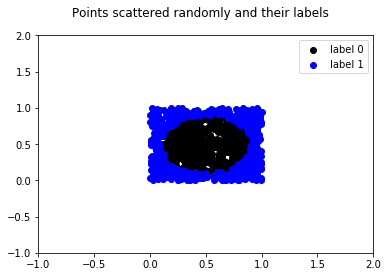

In [36]:
train_input,train_target = generate_disc_set(1000)
test_input,test_target = generate_disc_set(1000)
plot_set(train_input,train_target)

In [37]:
plt.show()

In [38]:
train_input,train_target = generate_disc_set(1000)
test_input,test_target = generate_disc_set(1000)

mu,std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)

mu,std = test_input.mean(0), test_input.std(0)
test_input.sub_(mu).div_(std)

tensor([[ 1.1105,  0.4693],
        [-0.8008,  1.2531],
        [ 0.2852, -0.7632],
        ...,
        [-0.7094,  0.7798],
        [-0.0386,  0.1875],
        [ 0.1119,  1.2942]])

In [39]:
train_target = target_to_onehot(train_target)


In [40]:
test_target = target_to_onehot(test_target)

In [41]:
batch_size = 100
n_epochs = 250
train_error = []
test_error = []
acc_loss = []
def train_model(model,train_input,train_target,test_input,test_target):
    criterion = MSELoss()
    optimizer = SGD(model.param(),lr = 0.01)
    for e in range(0,n_epochs):
        for input, targets in zip(train_input.split(batch_size),train_target.split(batch_size)):
            output = model(input)
            loss = criterion(output,targets)
            optimizer.zero_grad()
            model.backward(criterion.dloss(output,targets))
            optimizer.step()
            if e%50==0 :
                print('epoch: ',e,' loss: ',loss)
        acc_loss.append(loss.item())
        train_error.append(compute_nb_errors(model,train_input,train_target)/1000 * 100)
        test_error.append(compute_nb_errors(model,test_input,test_target)/1000 * 100)
        

In [42]:
model = Sequential((Linear(2,25),ReLU(),Linear(25,25),ReLU(),Linear(25,25),ReLU(),Linear(25,25),ReLU(),Linear(25,2)))

In [43]:
            
def compute_nb_errors(model,data_input,data_target):
    nb_errors = 0
    for input,targets in zip(data_input.split(batch_size),data_target.split(batch_size)):
        output = model(input)
        _,predicted_classes = torch.max(output,1)
        for i in range(0,output.size(0)):
            if(targets[i][predicted_classes[i]]!=1):
                nb_errors = nb_errors+1
                
    return nb_errors

In [44]:
train_model(model,train_input,train_target,test_input,test_target)

epoch:  0  loss:  tensor(226.0526)
epoch:  0  loss:  tensor(193.9262)
epoch:  0  loss:  tensor(159.7404)
epoch:  0  loss:  tensor(134.4137)
epoch:  0  loss:  tensor(125.2991)
epoch:  0  loss:  tensor(104.5778)
epoch:  0  loss:  tensor(100.6970)
epoch:  0  loss:  tensor(88.6774)
epoch:  0  loss:  tensor(82.6050)
epoch:  0  loss:  tensor(81.0176)
epoch:  50  loss:  tensor(48.0005)
epoch:  50  loss:  tensor(48.3848)
epoch:  50  loss:  tensor(47.8505)
epoch:  50  loss:  tensor(47.5351)
epoch:  50  loss:  tensor(48.0064)
epoch:  50  loss:  tensor(47.9839)
epoch:  50  loss:  tensor(47.2241)
epoch:  50  loss:  tensor(47.4293)
epoch:  50  loss:  tensor(47.4234)
epoch:  50  loss:  tensor(47.4187)
epoch:  100  loss:  tensor(34.0289)
epoch:  100  loss:  tensor(36.9160)
epoch:  100  loss:  tensor(36.7696)
epoch:  100  loss:  tensor(33.4622)
epoch:  100  loss:  tensor(36.1901)
epoch:  100  loss:  tensor(35.8055)
epoch:  100  loss:  tensor(33.2724)
epoch:  100  loss:  tensor(34.0978)
epoch:  100  lo

In [45]:
len(train_error)

250

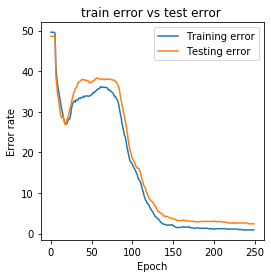

In [46]:
fig, axes = plt.subplots(1,1, figsize=(4, 4))
axes.plot(train_error, label='Training error')
axes.plot(test_error, label='Testing error')
axes.set_xlabel("Epoch")
axes.set_ylabel("Error rate")
axes.legend(loc='upper right')
axes.set_title("train error vs test error ")
fig.savefig("proj2.png")

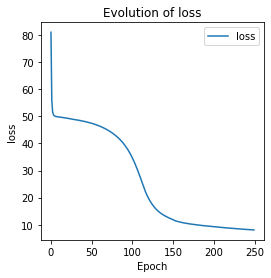

In [47]:
fig, axes = plt.subplots(1,1, figsize=(4, 4))
axes.plot(acc_loss, label='loss')
axes.set_xlabel("Epoch")
axes.set_ylabel("loss")
axes.legend(loc='upper right')
axes.set_title("Evolution of loss")
fig.savefig("proj2loss.png")

In [48]:
compute_nb_errors(model,train_input,train_target)/1000 * 100

0.8999999999999999

In [49]:
compute_nb_errors(model,test_input,test_target)/1000 * 100

2.4

In [50]:

all_loss = []
learningrates = [0.001,0.005,0.008,0.01]
for lr in learningrates:
    model = Sequential((Linear(2,25),ReLU(),Linear(25,25),ReLU(),Linear(25,25),ReLU(),Linear(25,25),ReLU(),Linear(25,2)))
    acc_loss = []
    criterion = MSELoss()
    optimizer = SGD(model.param(),lr = lr)
    for e in range(0,n_epochs):
        for input, targets in zip(train_input.split(batch_size),train_target.split(batch_size)):
            output = model(input)
            loss = criterion(output,targets)
            optimizer.zero_grad()
            model.backward(criterion.dloss(output,targets))
            optimizer.step()
        acc_loss.append(loss)
    all_loss.append(acc_loss)

        

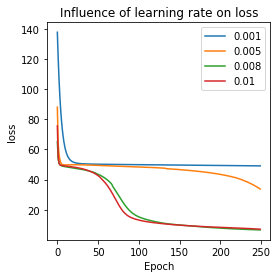

In [51]:
fig, axes = plt.subplots(1,1, figsize=(4, 4))
for i in range(len(all_loss)):
    axes.plot(all_loss[i], label =learningrates[i])

axes.set_xlabel("Epoch")
axes.set_ylabel("loss")
axes.legend(loc='upper right')
axes.set_title("Influence of learning rate on loss")
fig.savefig("proj2lr.png")

In [55]:
%run test.py

epoch:  0  loss:  tensor(61.5662)
epoch:  10  loss:  tensor(49.4743)
epoch:  20  loss:  tensor(49.2348)
epoch:  30  loss:  tensor(48.9207)
epoch:  40  loss:  tensor(48.5713)
epoch:  50  loss:  tensor(48.0536)
epoch:  60  loss:  tensor(47.2383)
epoch:  70  loss:  tensor(45.9154)
epoch:  80  loss:  tensor(43.7768)
epoch:  90  loss:  tensor(40.2191)
epoch:  100  loss:  tensor(34.0514)
epoch:  110  loss:  tensor(25.4626)
epoch:  120  loss:  tensor(18.9340)
epoch:  130  loss:  tensor(16.5647)
epoch:  140  loss:  tensor(15.3953)
epoch:  150  loss:  tensor(14.4247)
epoch:  160  loss:  tensor(13.7047)
epoch:  170  loss:  tensor(13.1906)
epoch:  180  loss:  tensor(12.7277)
epoch:  190  loss:  tensor(12.3340)
epoch:  200  loss:  tensor(11.9414)
epoch:  210  loss:  tensor(11.5012)
epoch:  220  loss:  tensor(11.0822)
epoch:  230  loss:  tensor(10.7545)
epoch:  240  loss:  tensor(10.4239)
train error :  1.9 %
test error :  3.4000000000000004 %
